In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Load dataset and GloVe word embedding from CSV file
data_path = '/content/drive/MyDrive/dataset/all-the-news-combined.csv'
glove_path = '/content/drive/MyDrive/glove/glove.6B.300d.txt'
data = pd.read_csv(data_path)
data.dropna(subset=['author', 'content'], inplace=True)  # Remove entries with missing author or content

<ipython-input-2-9dc082728e1b>:6: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [3]:
# Filter data to include only authors with a significant number (400 or more) of articles
author_counts = data['author'].value_counts()
frequent_authors = author_counts[author_counts >= 400].index

# List of grouped authors (not individuals) to be excluded from the analysis
authors_to_exclude = [
    "Associated Press",
    "Breitbart Jerusalem",
    "Breitbart London",
    "Breitbart News",
    "Editorial Board",
    "Fox News",
    "NPR Staff",
    "Post Editorial Board",
    "Post Staff Report",
    "Reuters",
    "The Editors"
]

# Filter out the authors in the exclusion list
data = data[data['author'].isin(frequent_authors) & ~data['author'].isin(authors_to_exclude)]

# Display the names of qualified authors
qualified_authors = data['author'].unique()
print("Qualified Authors:")
for author in qualified_authors:
    print(author)

Qualified Authors:
Camila Domonoske
Merrit Kennedy
Bill Chappell
Ian Hanchett
Katherine Rodriguez
Jerome Hudson
Charlie Spiering
AWR Hawkins
Warner Todd Huston
Jeff Poor
Trent Baker
Daniel Nussbaum
John Hayward
Pam Key
Joel B. Pollak
Charlie Nash
Alex Swoyer


In [4]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Function to preprocess text by removing digits, punctuation, and stop words, and applying lemmatization
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    return ' '.join(lemmatizer.lemmatize(word) for word in words if word not in stop_words)

# Apply preprocessing to the content of each article
data['processed_content'] = data['content'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
import numpy as np

# Function to load GloVe embeddings from file
def load_glove_embeddings(path):
    embeddings_index = {}
    dimension = None
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            if dimension is None:
                dimension = len(values) - 1  # Set the dimensionality of the vectors
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index, dimension

# Load GloVe embeddings
glove_embeddings, embedding_dim = load_glove_embeddings(glove_path)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize and fit tokenizer on the processed content
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['processed_content'])
sequences = tokenizer.texts_to_sequences(data['processed_content'])

# Determine the optimal length of sequences for padding
sequence_lengths = [len(seq) for seq in sequences]
maxlen = int(np.percentile(sequence_lengths, 95))  # Using the 95th percentile to determine maxlen

# Pad sequences to ensure consistent length
X = pad_sequences(sequences, maxlen=maxlen)

# Prepare the embedding matrix by mapping GloVe vectors to the corresponding words in our tokenizer
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode author names into categorical labels
encoder = LabelEncoder()
y = encoder.fit_transform(data['author'])

# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, GRU, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Define the LSTM model architecture
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True),
    SpatialDropout1D(0.2),
    LSTM(128, return_sequences=True, dropout=0.2),
    Dropout(0.25),
    LSTM(128, return_sequences=True, dropout=0.2),
    Dropout(0.25),
    LSTM(64, dropout=0.2),
    Dropout(0.2),
    Dense(len(set(y)), activation='softmax')
])

# Compile the LSTM model with defined optimizer and loss function
optimizer = RMSprop(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to halt training when validation loss ceases to decrease
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Train the LSTM model with early stopping
history_lstm = model_lstm.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the LSTM model on the test data
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss_lstm}, Test Accuracy: {test_acc_lstm}")

# Predict labels for the test set and generate a classification report
y_pred_lstm = model_lstm.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1) # Convert probabilities to class labels
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_classes_lstm, target_names=encoder.classes_))

Epoch 1/30
110/110 [==============================] - 24s 169ms/step - loss: 1.5178 - accuracy: 0.5435 - val_loss: 0.7339 - val_accuracy: 0.7483
Epoch 2/30
110/110 [==============================] - 16s 142ms/step - loss: 0.7468 - accuracy: 0.7486 - val_loss: 0.7755 - val_accuracy: 0.7237
Epoch 3/30
110/110 [==============================] - 15s 132ms/step - loss: 0.6546 - accuracy: 0.7700 - val_loss: 0.6933 - val_accuracy: 0.7586
Epoch 4/30
110/110 [==============================] - 15s 133ms/step - loss: 0.6202 - accuracy: 0.7821 - val_loss: 0.5695 - val_accuracy: 0.7945
Epoch 5/30
110/110 [==============================] - 13s 119ms/step - loss: 0.5618 - accuracy: 0.8027 - val_loss: 0.6406 - val_accuracy: 0.7791
Epoch 6/30
110/110 [==============================] - 12s 112ms/step - loss: 0.5147 - accuracy: 0.8185 - val_loss: 0.5325 - val_accuracy: 0.8122
Epoch 7/30
110/110 [==============================] - 12s 112ms/step - loss: 0.4645 - accuracy: 0.8340 - val_loss: 0.5515 - val_ac

In [8]:
# Define the GRU model architecture
model_gru = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True),
    SpatialDropout1D(0.2),
    GRU(128, return_sequences=True, dropout=0.2),
    GRU(128, return_sequences=True, dropout=0.2),
    GRU(64, dropout=0.2),
    Dropout(0.2),
    Dense(len(set(y)), activation='softmax')
])

# Compile the GRU model with defined optimizer and loss function
optimizer = RMSprop(learning_rate=0.001)
model_gru.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to halt training when validation loss ceases to decrease
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Train the GRU model with early stopping
history_gru = model_gru.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the GRU model on the test data
test_loss_gru, test_acc_gru = model_gru.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss_gru}, Test Accuracy: {test_acc_gru}")

# Predict labels for the test set and generate a classification report
y_pred_gru = model_gru.predict(X_test)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1) # Convert probabilities to class labels
print("GRU Classification Report:")
print(classification_report(y_test, y_pred_classes_gru, target_names=encoder.classes_))

Epoch 1/30
110/110 [==============================] - 18s 130ms/step - loss: 1.1017 - accuracy: 0.6680 - val_loss: 0.7544 - val_accuracy: 0.7443
Epoch 2/30
110/110 [==============================] - 12s 112ms/step - loss: 0.7472 - accuracy: 0.7424 - val_loss: 0.6163 - val_accuracy: 0.7745
Epoch 3/30
110/110 [==============================] - 11s 104ms/step - loss: 0.6058 - accuracy: 0.7830 - val_loss: 0.5333 - val_accuracy: 0.8122
Epoch 4/30
110/110 [==============================] - 11s 101ms/step - loss: 0.5173 - accuracy: 0.8192 - val_loss: 0.5726 - val_accuracy: 0.8054
Epoch 5/30
110/110 [==============================] - 10s 95ms/step - loss: 0.4543 - accuracy: 0.8412 - val_loss: 0.4806 - val_accuracy: 0.8305
Epoch 6/30
110/110 [==============================] - 9s 84ms/step - loss: 0.4018 - accuracy: 0.8531 - val_loss: 0.4508 - val_accuracy: 0.8459
Epoch 7/30
110/110 [==============================] - 10s 90ms/step - loss: 0.3516 - accuracy: 0.8715 - val_loss: 0.4741 - val_accura

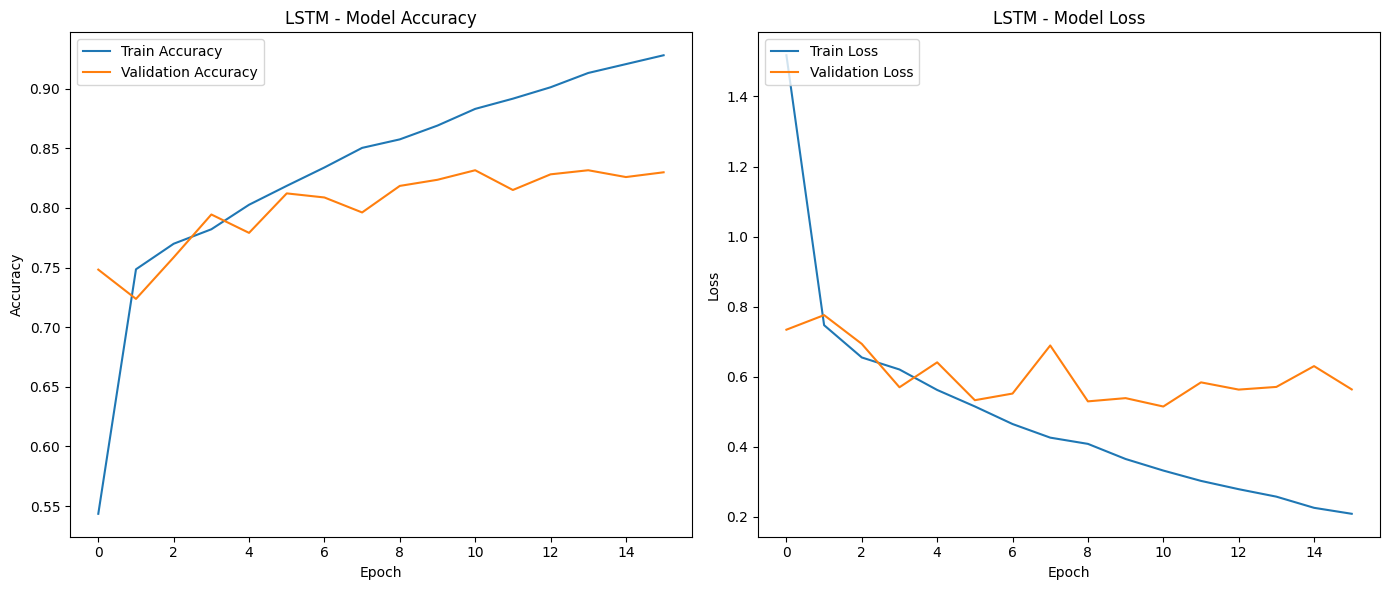

LSTM Model Evaluation
Accuracy: 0.83
Macro Precision: 0.81
Macro Recall: 0.81
Macro F1 Score: 0.80


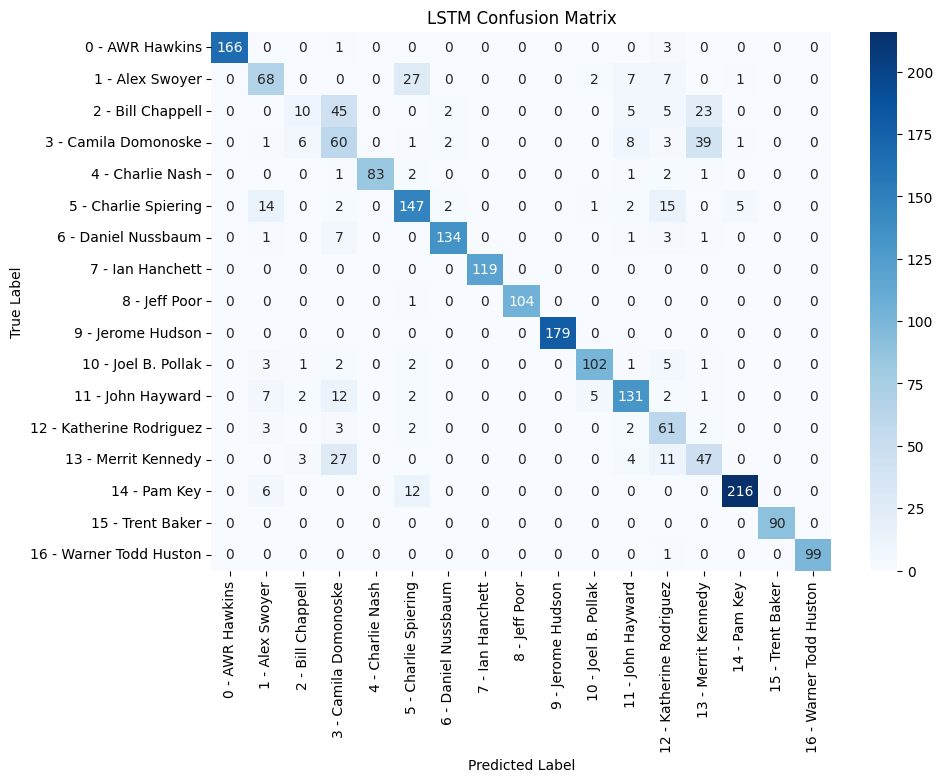

Confusion Matrix Breakdown for LSTM:
Author 0 - TP: 166, FP: 0, FN: 4, TN: 2019
Author 1 - TP: 68, FP: 35, FN: 44, TN: 2042
Author 2 - TP: 10, FP: 12, FN: 80, TN: 2087
Author 3 - TP: 60, FP: 100, FN: 61, TN: 1968
Author 4 - TP: 83, FP: 0, FN: 7, TN: 2099
Author 5 - TP: 147, FP: 49, FN: 41, TN: 1952
Author 6 - TP: 134, FP: 6, FN: 13, TN: 2036
Author 7 - TP: 119, FP: 0, FN: 0, TN: 2070
Author 8 - TP: 104, FP: 0, FN: 1, TN: 2084
Author 9 - TP: 179, FP: 0, FN: 0, TN: 2010
Author 10 - TP: 102, FP: 8, FN: 15, TN: 2064
Author 11 - TP: 131, FP: 31, FN: 31, TN: 1996
Author 12 - TP: 61, FP: 57, FN: 12, TN: 2059
Author 13 - TP: 47, FP: 68, FN: 45, TN: 2029
Author 14 - TP: 216, FP: 7, FN: 18, TN: 1948
Author 15 - TP: 90, FP: 0, FN: 0, TN: 2099
Author 16 - TP: 99, FP: 0, FN: 1, TN: 2089


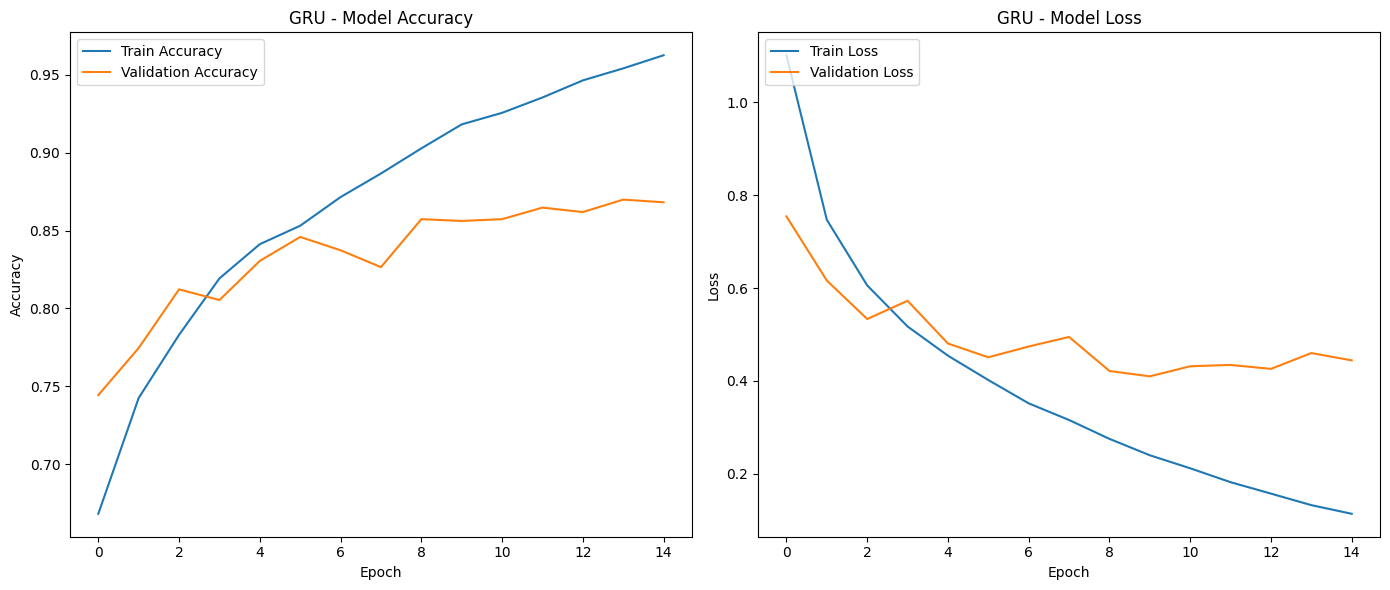

GRU Model Evaluation
Accuracy: 0.86
Macro Precision: 0.85
Macro Recall: 0.84
Macro F1 Score: 0.83


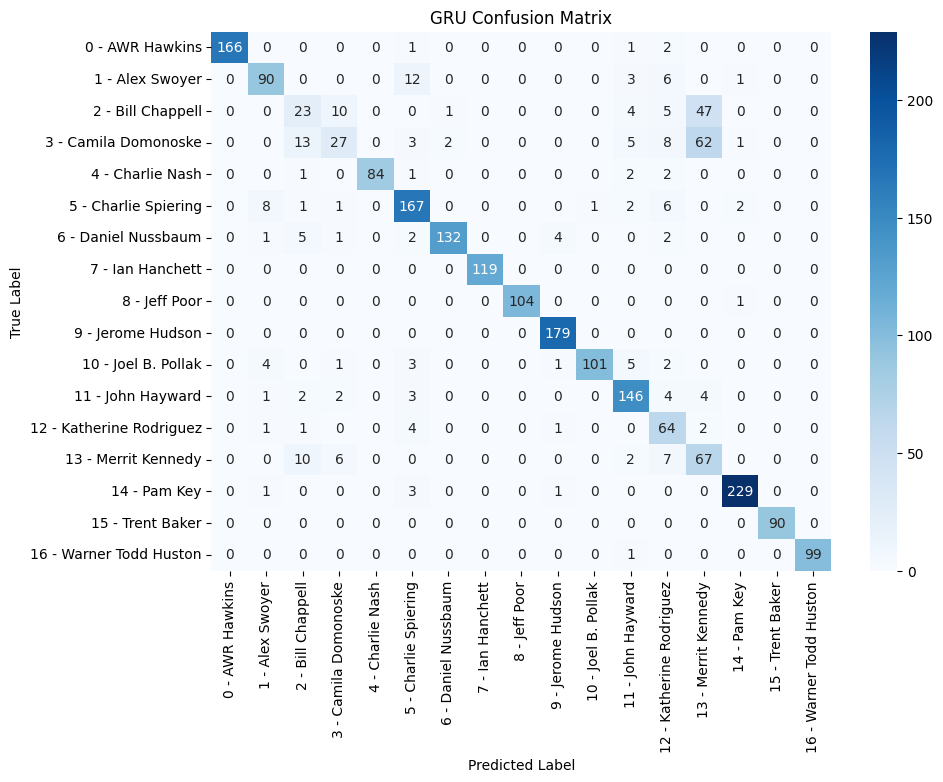

Confusion Matrix Breakdown for GRU:
Author 0 - TP: 166, FP: 0, FN: 4, TN: 2019
Author 1 - TP: 90, FP: 16, FN: 22, TN: 2061
Author 2 - TP: 23, FP: 33, FN: 67, TN: 2066
Author 3 - TP: 27, FP: 21, FN: 94, TN: 2047
Author 4 - TP: 84, FP: 0, FN: 6, TN: 2099
Author 5 - TP: 167, FP: 32, FN: 21, TN: 1969
Author 6 - TP: 132, FP: 3, FN: 15, TN: 2039
Author 7 - TP: 119, FP: 0, FN: 0, TN: 2070
Author 8 - TP: 104, FP: 0, FN: 1, TN: 2084
Author 9 - TP: 179, FP: 7, FN: 0, TN: 2003
Author 10 - TP: 101, FP: 1, FN: 16, TN: 2071
Author 11 - TP: 146, FP: 25, FN: 16, TN: 2002
Author 12 - TP: 64, FP: 44, FN: 9, TN: 2072
Author 13 - TP: 67, FP: 115, FN: 25, TN: 1982
Author 14 - TP: 229, FP: 5, FN: 5, TN: 1950
Author 15 - TP: 90, FP: 0, FN: 0, TN: 2099
Author 16 - TP: 99, FP: 0, FN: 1, TN: 2089


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Function to plot training history for accuracy and loss
def plot_history(history, title):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title + ' - Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title + ' - Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    labels = [f'{i} - {class_name}' for i, class_name in enumerate(classes)]

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return cm

# Function to evaluate model performance
def evaluate_model(name, y_true, y_pred, classes, history):
    plot_history(history, name)  # Plot the training and validation history
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{name} Model Evaluation")
    print("Accuracy: {:.2f}".format(accuracy))
    print("Macro Precision: {:.2f}".format(precision))
    print("Macro Recall: {:.2f}".format(recall))
    print("Macro F1 Score: {:.2f}".format(f1))

    cm = plot_confusion_matrix(y_true, y_pred, classes, name)  # Plot the confusion matrix

    # Detailed breakdown of the confusion matrix
    print(f"Confusion Matrix Breakdown for {name}:")
    for i in range(len(classes)):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        print(f"Author {i} - TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

# Evaluating LSTM model
evaluate_model("LSTM", y_test, y_pred_classes_lstm, encoder.classes_, history_lstm)

# Evaluating GRU model
evaluate_model("GRU", y_test, y_pred_classes_gru, encoder.classes_, history_gru)

In [10]:
# Save the LSTM and GRU models to the specified directory
model_lstm.save('/content/model_lstm.h5')  # saves the model in HDF5 format
model_gru.save('/content/model_gru.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import pickle

# Save the tokenizer
with open('/content/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the LabelEncoder
with open('/content/encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
import zipfile

# Create a zip file containing the models and other necessary files
with zipfile.ZipFile('/content/model_files.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('/content/model_lstm.h5', arcname='model_lstm.h5')
    zipf.write('/content/model_gru.h5', arcname='model_gru.h5')
    zipf.write('/content/tokenizer.pickle', arcname='tokenizer.pickle')
    zipf.write('/content/encoder.pickle', arcname='encoder.pickle')